In [1]:
import torch
import torch.nn as nn
from torch import tensor, autograd
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from IPython.display import clear_output

class Generator(nn.Module):
    def __init__(self, in_dim=1, out_dim=1, n_hidden_units=20, n_hidden_layers=2, 
                 activation=nn.Tanh(),
                 output_tan=True):
        
        super(Generator, self).__init__()

        # input
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(in_dim, n_hidden_units))
        self.layers.append(activation)
        
        # hidden
        for l in range(n_hidden_layers):
            self.layers.append(nn.Linear(n_hidden_units, n_hidden_units))
            self.layers.append(activation)
            
        # output
        self.layers.append(nn.Linear(n_hidden_units, out_dim))
        if output_tan:
            self.layers.append(nn.Tanh())

    def forward(self, x):
        for i in range(len(self.layers)):
            x = self.layers[i](x)
        return x

class Discriminator(nn.Module):
    def __init__(self, in_dim=1, out_dim=1, n_hidden_units=20, n_hidden_layers=2, 
                 activation=nn.Tanh(), 
                 unbounded=False):
        
        super(Discriminator, self).__init__()
        
        # input
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(in_dim, n_hidden_units))
        self.layers.append(activation)
        
        # hidden
        for l in range(n_hidden_layers):
            self.layers.append(nn.Linear(n_hidden_units, n_hidden_units))
            self.layers.append(activation)
        
        # output
        self.layers.append(nn.Linear(n_hidden_units, out_dim))
        if not unbounded:
            # unbounded for WGAN (no sigmoid)
            self.layers.append(nn.Sigmoid())

    def forward(self, x):
        for i in range(len(self.layers)):
            x = self.layers[i](x)
        return x

def realtime_vis(g_loss, d_loss, t, preds, analytic_fn, dx_dt, d2x_dt2, savefig=False, fname=None):
    fig, ax = plt.subplots(1,3,figsize=(20,6))
    steps = len(g_loss)
    epochs = np.arange(steps)

    ax[0].plot(epochs, [d[0] for d in d_loss], label='d_loss_fake', color='g')
    ax[0].plot(epochs, [d[1] for d in d_loss], label='d_loss_real', color='b')
    ax[0].plot(epochs, g_loss, label='g_loss', color='r')
    ax[0].legend()
    ax[0].set_title('Losses')

    ax[1].plot(t, analytic_fn(t), label='true')
    ax[1].plot(t, preds, '--', label='pred')
    ax[1].legend()
    ax[1].set_title('X Pred')

    ax[2].plot(t, dx_dt, label='dx_dt')
    ax[2].plot(t, d2x_dt2, label='d2x_dt2')
    ax[2].plot(t, preds, '--', label='x')
    ax[2].legend()
    ax[2].set_title('Derivatives')

    if not savefig:
        plt.show()
    else:
        plt.savefig(fname)

def diff(x, t):
    dx_dt, = autograd.grad(x, t,
                           grad_outputs=x.data.new(x.shape).fill_(1),
                           create_graph=True)
    return dx_dt

def train_GAN_SHO(
                num_epochs,
                activation=nn.Tanh(),
                g_hidden_units=10,
                d_hidden_units=10,
                g_hidden_layers=2,
                d_hidden_layers=2,
                d_lr=0.001,
                g_lr=0.001,
                d_betas=(0.9, 0.999),
                g_betas=(0.9, 0.999),
                G_iters=1,
                D_iters=1,
    
                t_low=0,
                t_high=10,
                x0=0,
                dx_dt0=.5,
                n=100,
                m=1.,
                k=1.,
                real_label=1,
                fake_label=0,
                
                logging=True,
                realtime_plot=False,
                
                soft_labels=False,
                real_data=False,
                loss_diff=.1,
                max_while=20,
                
                wgan=False,
                clip=.1,
                gradient_penalty=False,
                gp_hyper=0.1,
                
                systemOfODE=False,
                savefig=False,
                fname=None,
                device=None,
                check_every=100):

    """
    function to perform training of generator and discriminator for num_epochs
    equation: simple harmonic oscillator (SHO)
    gan hacks:
        - wasserstein + clipping / wasserstein GP
        - label smoothing
        - while loop iters
    """
    if savefig and realtime_plot:
        raise Exception('savefig and realtime_plot both True. Assuming you dont want that.')

    if wgan:
        fake_label = -1

    # initialize nets
    G = Generator(in_dim=1, out_dim=1,
                  n_hidden_units=g_hidden_units,
                  n_hidden_layers=g_hidden_layers,
                  activation=activation, # twice diff'able activation
                  output_tan=True) # output range should be (-1,1) if True

    D = Discriminator(in_dim=1, out_dim=1,
                      n_hidden_units=d_hidden_units,
                      n_hidden_layers=d_hidden_layers,
                      activation=activation,
                      unbounded=wgan) # true for WGAN

    # grid
    t_torch = torch.linspace(t_low, t_high, n, dtype=torch.float, requires_grad=True).reshape(-1,1)
    t_np = np.linspace(t_low, t_high, n).reshape(-1,1)

    delta_t = t_torch[1]-t_torch[0]
    def get_batch():
        """ perturb grid """
        return t_torch + delta_t * torch.randn_like(t_torch) / 3

    # labels
    real_label_vec = torch.full((n,), real_label).reshape(-1,1)
    fake_label_vec = torch.full((n,), fake_label).reshape(-1,1)

    # optimization
    if wgan:
        criterion = lambda y_true, y_pred: torch.mean(y_true * y_pred)
    else:
        criterion = nn.BCELoss()

    optiG = torch.optim.Adam(G.parameters(), lr=g_lr, betas=g_betas)
    optiD = torch.optim.Adam(D.parameters(), lr=d_lr, betas=d_betas)

    # logging
    D_losses = []
    G_losses = []

    analytic_oscillator = lambda t: x0*torch.cos(t) + dx_dt0*torch.sin(t)
    analytic_oscillator_np = lambda t: x0*np.cos(t) + dx_dt0*np.sin(t)

    def produce_SHO_preds(G, t):
        x_raw = G(t)
        
        # adjust for initial conditions on x and dx_dt
        x_adj = x0 + (1 - torch.exp(-t)) * dx_dt0 + ((1 - torch.exp(-t))**2) * x_raw

        dx_dt = diff(x_adj, t)
        d2x_dt2 = diff(dx_dt, t)

        return x_adj, dx_dt, d2x_dt2

    def produce_SHO_preds_system(G, t):
        x_pred = G(t)
        
        # x condition
        x_adj = x0 + (1 - torch.exp(-t)) * dx_dt0 + ((1 - torch.exp(-t))**2) * x_pred
        
        # dx_dt (directly from NN output, x_pred)
        dx_dt = diff(x_pred, t)
        
        # u condition guarantees that dx_dt = u (first equation in system)
        u_adj = torch.exp(-t) * dx_dt0 + 2 * (1 - torch.exp(-t)) * torch.exp(-t) * x_pred + (1 - torch.exp(-t)) * dx_dt
        
        # compute du_dt = d2x_dt2
        du_dt = diff(u_adj, t)

        return x_adj, u_adj, du_dt

    for epoch in range(num_epochs):

        ## =========
        ##  TRAIN G
        ## =========

        for p in D.parameters():
            p.requires_grad = False # turn off computation for D when updating G

        t = get_batch()
        if real_data:
            real = analytic_oscillator(t)
            
        ## DEBUGGING
        if (epoch//100) % 2 == 0:
            print('running g')
            G_iters=1
            D_iters=0
        else:
            print('running d')
            D_iters=1
            G_iters=0

        for i in range(G_iters):

            if systemOfODE:
                x_adj, u_adj, du_dt = produce_SHO_preds_system(G, t)
                d2x_dt2 = du_dt
                
            else:
                x_adj, dx_dt, d2x_dt2 = produce_SHO_preds(G, t)

            if real_data:
                fake = x_adj
            else:
                real = x_adj
                fake = -(m/k)*d2x_dt2

            if wgan:
                # WGAN loss from paper
                g_loss = torch.mean(-D(fake))
                
            else:
                # generator loss
                g_loss = criterion(D(fake), real_label_vec)

            optiG.zero_grad() # zero grad before backprop
            g_loss.backward(retain_graph=True)
            if wgan and not gradient_penalty:
                g_grad_norm = nn.utils.clip_grad_norm_(G.parameters(), clip)
            optiG.step()

        ## =========
        ##  TRAIN D
        ## =========

        for p in D.parameters():
            p.requires_grad = True # turn on computation for D

        for i in range(D_iters):

            if soft_labels:
                real_label_vec_ = real_label_vec + (-.2 + .4 * torch.rand_like(real_label_vec))
                fake_label_vec_ = fake_label_vec + (-.2 + .4 * torch.rand_like(fake_label_vec))
            else:
                real_label_vec_ = real_label_vec
                fake_label_vec_ = fake_label_vec

            ## WGAN - GP penalty
            norm_penalty = torch.zeros(1)
            
            if wgan and gradient_penalty:
                total_norm = torch.zeros(1)
                
                # sample epsilon for each sample in the batch
                eps_mix = torch.rand(real.shape[0]) 
                x_mix = torch.zeros_like(eps_mix)
                
                for i,eps in enumerate(eps_mix):
                    # assign x_mix to mixture according to epsilon
                    x_mix[i] = eps * real[i] + (1-eps) * fake[i]

                x_mix = x_mix.reshape(-1,1)

                # calculate d(D(mix))/d(x_mix)
                mix_preds = D(x_mix)
                mix_grad = diff(mix_preds, x_mix)
                
                # calculate norm for each sample
                total_norm = torch.norm(mix_grad, dim=1)
                norm_penalty = gp_hyper * torch.pow(total_norm - 1, 2)

            if wgan:
                # loss used in WGAN-GP paper
                d_loss = torch.mean(D(fake) - D(real) + norm_penalty)
            else:
                # discriminator loss
                real_loss = criterion(D(real), real_label_vec_)
                fake_loss = criterion(D(fake), fake_label_vec_)
                d_loss = real_loss + fake_loss + norm_penalty
            
            optiD.zero_grad()
            d_loss.backward(retain_graph=True)
            if wgan and not gradient_penalty:
                d_grad_norm = nn.utils.clip_grad_norm_(D.parameters(), clip)
            optiD.step()

        ## ========
        ## Logging
        ## ========

        if logging:
            print('[%d/%d] D_Loss : %.4f Loss_G: %.4f' % (epoch, num_epochs, d_loss.item(), g_loss.item()))

#         d_loss_no_gp = torch.mean(D(fake) - D(real))
        d_loss_fake = torch.mean(D(fake))
        d_loss_real = torch.mean(-D(real))
        D_losses.append((d_loss_fake.item(), d_loss_real.item()))
        G_losses.append(g_loss.item())

        if (epoch > 0 and realtime_plot and epoch % check_every == 0) or (epoch == num_epochs - 1):
            # either every time or on last epoch, show plots
            # if savefig is True, the figure will be saved
            # (only on last epoch), because we make sure both are not true
            
            clear_output(True)
                
            if systemOfODE:
                x_adj, u_adj, du_dt = produce_SHO_preds_system(G, t)
                dx_dt = u_adj
                d2x_dt2 = du_dt
                
            else:

                x_adj, dx_dt, d2x_dt2 = produce_SHO_preds(G, t_torch)
            
            realtime_vis(G_losses, D_losses, t_np, x_adj.detach().numpy(), analytic_oscillator_np,
                            dx_dt.detach().numpy(), d2x_dt2.detach().numpy(), savefig=savefig, fname=fname)

    return G, D, G_losses, D_losses

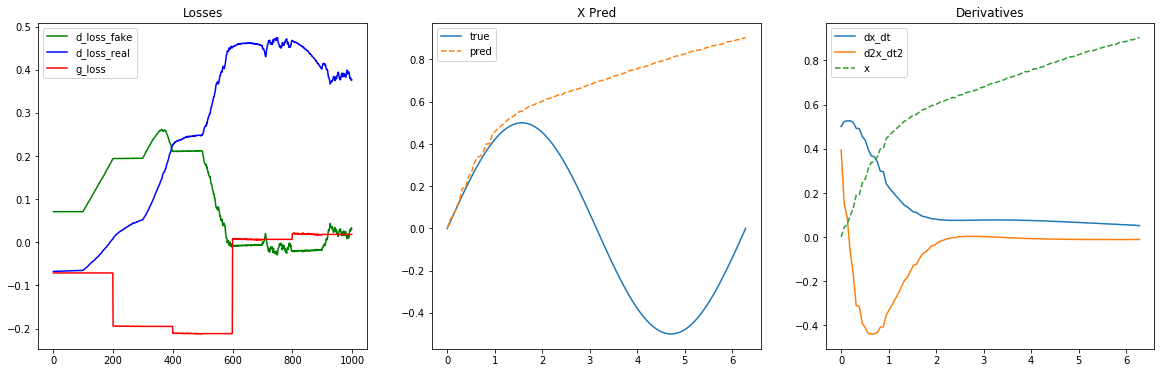

CPU times: user 32min 19s, sys: 6min 46s, total: 39min 5s
Wall time: 5min 13s


In [2]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
    
                              # EPOCHS
                              1000, 
                                      
                              # NETWORKS
                              activation=nn.Tanh(),
                              g_hidden_units=20, 
                              g_hidden_layers=2,
                              d_hidden_units=30, 
                              d_hidden_layers=2,
                              
                              # FROM WGAN-GP PAPER
                              G_iters=1,
                              D_iters=1,
                              d_lr=0.0001,
                              g_lr=0.0001,
                              d_betas=(0., 0.9),
                              g_betas=(0., 0.9),
                                      
                              # PROBLEM      
                              t_low=0,
                              t_high=2*np.pi,
                              n=100,
                              x0=0.,
                              dx_dt0=.5,
                                 
                              # VIZ
                              logging=False,
                              realtime_plot=True,
                              
                              # Hacks
                              real_data=False,                                      
                              soft_labels=False,
                              
                              # WGAN
                              wgan=True,
                              gradient_penalty=True,
                              gp_hyper=1.,
                              
                              # SYSTEM
                              systemOfODE=True,
                              check_every=1
)

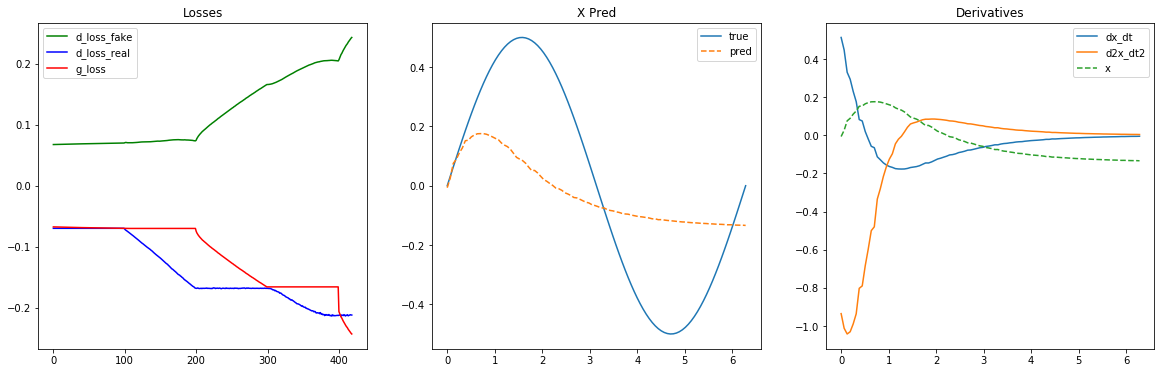

running g


In [ ]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
    
                              # EPOCHS
                              1000, 
                                      
                              # NETWORKS
                              activation=nn.Tanh(),
                              g_hidden_units=20, 
                              g_hidden_layers=2,
                              d_hidden_units=30, 
                              d_hidden_layers=2,
                              
                              # FROM WGAN-GP PAPER
                              G_iters=1,
                              D_iters=1,
                              d_lr=0.0001,
                              g_lr=0.0001,
                              d_betas=(0., 0.9),
                              g_betas=(0., 0.9),
                                      
                              # PROBLEM      
                              t_low=0,
                              t_high=2*np.pi,
                              n=100,
                              x0=0.,
                              dx_dt0=.5,
                                 
                              # VIZ
                              logging=False,
                              realtime_plot=True,
                              
                              # Hacks
                              real_data=True,                                      
                              soft_labels=False,
                              
                              # WGAN
                              wgan=True,
                              gradient_penalty=True,
                              gp_hyper=1.,
                              
                              # SYSTEM
                              systemOfODE=True,
                              check_every=1
)

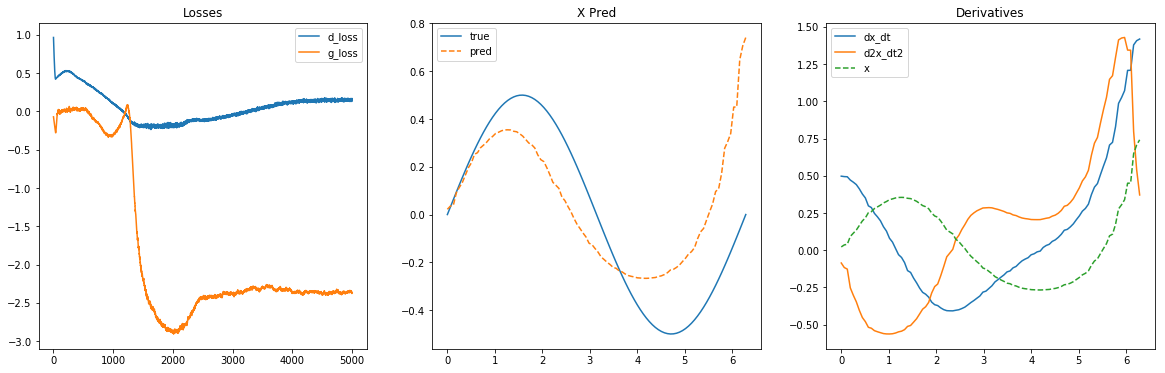

CPU times: user 1h 17min 25s, sys: 21min 16s, total: 1h 38min 42s
Wall time: 9min 29s


In [114]:
%%time
torch.manual_seed(42)
G,D,G_loss,D_loss = train_GAN_SHO(
    
                              # EPOCHS
                              5000, 
                                      
                              # NETWORKS
                              activation=nn.Tanh(),
                              g_hidden_units=20, 
                              g_hidden_layers=2,
                              d_hidden_units=30, 
                              d_hidden_layers=2,
                              
                              # FROM WGAN-GP PAPER
                              G_iters=1,
                              D_iters=5,
                              d_lr=0.0001,
                              g_lr=0.0001,
                              d_betas=(0., 0.9),
                              g_betas=(0., 0.9),
                                      
                              # PROBLEM      
                              t_low=0,
                              t_high=2*np.pi,
                              n=100,
                              x0=0.,
                              dx_dt0=.5,
                                 
                              # VIZ
                              logging=False,
                              realtime_plot=True,
                              
                              # Hacks
                              real_data=False,                                      
                              soft_labels=False,
                              
                              # WGAN
                              wgan=True,
                              gradient_penalty=True,
                              gp_hyper=1.,
                              
                              # SYSTEM
                              systemOfODE=True
)

In [ ]:
class TorchSin(torch.nn.Module):
    """
    Swish activation function
    """
    def __init__(self):
        super(TorchSin, self).__init__()

    def forward(self, x):
        return torch.sin(x)